# Introduction

This notebook is aiming to broadly introduce all the major components of the toolsforexperiments suite.
the document is currently still work in progress, but already a decent starting point for a few things.

- Prerequisites: 
  - you should know the qcodes basics
  - have a look at the 'dummy_measurement_without_server' example before

# Imports

In [2]:
from pprint import pprint
import time

import numpy as np
from matplotlib import pyplot as plt
import h5py


from qcodes import Instrument, Station, find_or_create_instrument
from plottr.data import datadict_storage as dds, datadict as dd

# The instrument server

The role of the instrument server is to manage access to instruments (both real and virtual), so they can be used from multiple processes. 
It's not strictly necessary to use it, and its designed such that using instruments through the server can be used also to talk to instruments that are instantiated directly.

Start the instrumentserver from the commandline (in an env't that has qcodes and the instrumentserver package installed) in a directory that will be the working directory for the server.

```bash
    $ instrumentserver --gui True
```

Because no instruments are instantiated at this point, we get an empty window reflecting the blank qcodes station living inside the server.
We can already create a client in this notebook that connects to the instrumentserver:

In [3]:
from instrumentserver.client import Client as InstrumentClient
cli = InstrumentClient() # connect to default host (localhost) and default port (5555)

We will now see how we can make use of the fact that we can talk to the instrumentserver from multiple processes. 
We'll create a virtual instrument (something with no direct counterpart on the hardware side) that allows us to manage arbitrary experiment parameters that we can access across the setup (a fancy way to keep track of important variables). After that, we'll set up some dummy instruments and perform some fake data acquisition with them.

## Parameter manager

We'll first launch the *parameter manager*. Because it has a dedicated GUI we run it as a standalone program. 
From a command line prompt we can launch the example script that's located in the folder of this manual (again, make sure to do this within an env't that has the instrumentserver package installed):

```bash
    $ python run_parameter_manager.py
```

We'll simply get an empty window now.
The bottom of the window allows us to add arbitrary parameters and values, where dots serve as hierarchy separators (like objects and their children in python).
Let's add a few parameters, let's say `qubit.frequency`, `qubit.pipulse.len`, `qubit.pipulse.amp` and give them some arbitrary values.
We'll see something like this:

![Parameter manager window](figures/parammgr.png)

Because parameters live in the instrumentserver we can access the values here by creating a 'Proxy' instrument that forwards all requests to the 'real' instrument.

In [17]:
params = cli.get_instrument('params') # 'params' is the name the startup script gave the instrument

# simply output the value of the pi pulse length:
params.qubit.pipulse.len()

40

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_getBluePrintFromServer',
 '_getProxyMethods',
 '_getProxyParameters',
 '_getProxySubmodules',
 '_makeProxyMethod',
 '_meta_attrs',
 '_name',
 '_short_name',
 'add_function',
 'add_parameter',
 'add_submodule',
 'ancestors',
 'askServer',
 'bp',
 'call',
 'cli',
 'createFromParamDict',
 'delegate_attr_dicts',
 'delegate_attr_objects',
 'fromFile',
 'fromParamDict',
 'full_name',
 'functions',
 'get',
 'has_param',
 'host',
 'initKwargsFromBluePrint',
 'list',
 'load_metadata',
 'log',
 'metadata',
 'name',
 'name_parts',
 'omit_delegate_attrs',
 'parame

**A note on synchronization of available instrument parameters between clients** 

Currently, automatic synchronization of registered parameters (and GUI-displayed values of parameters) is an outstanding feature. (This will be implemented soon.)

*It is, however, important to stress that the actual value of any parameter is stored in the server. That means that calling a parameter to get its value or to set it always results in the correct outcome.*

After we change values in the parameter manager from our interactive notebook (or a console), we need to manually refresh the GUI to make those visible:

In [6]:
# after executing, go to the GUI and press the refresh icon in the upper left to see the change.
params.qubit.pipulse.len(100)

The same goes for adding new parameters after all clients are connected.
We can add new parameters very easily from any client, but to make them visible we need to refresh the other clients:

In [7]:
# this will only be available in the GUI after pressing the refresh button.
params.add_parameter('qubit.anharmonicity', initial_value=-150.0, unit='MHz')

Conversely, if we add a parameter in the instrument GUI (let's say: `resonator.frequency`), we need to update the other clients (like the one in our notebook) before being able to access it:

In [8]:
# our proxy instrument does not yet know that the parameter exist right after creating it in the GUI.
# Only the proxy instrument of the GUI, as well as the instrumentserver, have that information at this moment.
params.resonator.frequency()

AttributeError: 'ProxyInstrumentModule' object and its delegates have no attribute 'resonator'

To sync a local client, we can call it's `update` method:

In [9]:
params.update()
params.resonator.frequency()

AttributeError: 'ProxyInstrumentModule' object and its delegates have no attribute 'resonator'

## Adding instruments to the server

When using 'vanilla' qcodes, we would simply create a qcodes station in our working kernel, then add instruments by instantiating the corresponding driver classes.
When using the instrumentserver to manage our instrument instances, we instead want to instantiate inside the station that the server runs.

As an example, we will add a dummy instrument that behaves like a vector network analyzer and simulates a resonator response.
Only the server will instantiate it, so instead of importing the driver, we pass the import path (of course, needs to be known in the environment that the server is running in).

In [12]:
vna = cli.create_instrument(
    'instrumentserver.testing.dummy_instruments.rf.ResonatorResponse', 
    'vna',  # this is the name of the instrument in the server station
    f0=6.789e9,  # the resonance frequency of the mock resonator
    df=1e6,  # the linewidth
)

## Using the parameter manager in measurements

Refer to [measurement_notebook](https://github.com/toolsforexperiments/recipes/blob/master/dummy_measurement_without_server/measurement_notebook.ipynb) for a more in depth guide example of the measurement we are taking. 

### Variable flux tunning resonator.

We first perform a simple test by tunning a flux resonator.
We initilize a flux control instrument in the server and add the flux parameter into the parameter manager.

In [11]:
fluxControl = cli.create_instrument(
    'instrumentserver.testing.dummy_instruments.rf.FluxControl',
    'flux',
    resonator_instrument='vna')

#params.add_parameter('flux_control.flux', initial_value=-0.25, unit='V')

Once the flux instrument is ready we can acquire and plot the trace.

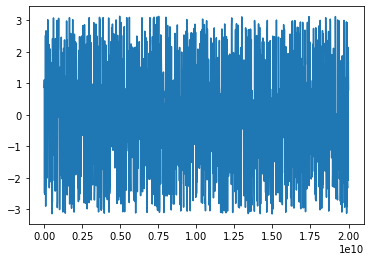

In [17]:
def acquire_flux_trace():
    # just acquire a trace and plot. The resonance frequency should change when changing the flux.
    fluxControl.flux(params.flux_control.flux())

    f_vals = vna.frequency()
    s11_vals = vna.data()

    fig, ax = plt.subplots(1, 1)
    ax.plot(f_vals, np.angle(s11_vals))

acquire_flux_trace()

We can now change the flux from the parameter manager and see the change in the trace when we measure it again.

In [ ]:
params.flux_control.flux(-0.35) #this step can also be performed by manually changing the value through the GUI
acquire_flux_trace()

### Performing a measurment and influencing it.

We can perform a measurement and change its parameter the same way.

In [ ]:
#Defining our measurement based on the previously mentioned notebook
def measure_flux_sweep(start, stop, steps, plot=True):

    vna.resonator_frequency(params.resonator.frequency()) # updating the vna resonator frequency -- in a real measurement this happens of course in hardware...

    with dds.DDH5Writer(DATADIR, 
        dd.DataDict(flux = dict(unit='Phi0'),
                    frequency = dict(unit='Hz'),
                    s11 = dict(axes=['flux', 'frequency'])),
        name='FluxSweep') as writer:

        for flux_val in np.linspace(start, stop, steps):
            fluxControl.flux(flux_val)
            
            writer.add_data(
                flux = [flux_val],
                frequency = vna.frequency().reshape(1,-1),
                s11 = vna.data().reshape(1,-1),
            )

    if plot:
        # this is plotting the data
        data_as_grid = dd.datadict_to_meshgrid(writer.datadict)
        flux_data = data_as_grid.data_vals('flux')
        frq_data = data_as_grid.data_vals('frequency')
        s11_data = data_as_grid.data_vals('s11')

        fig, ax = plt.subplots(1, 1)
        ax.imshow(
            np.angle(s11_data.T), 
            aspect='auto', origin='lower',
            extent=[flux_data.min(), flux_data.max(), frq_data.min(), frq_data.max()]
        )
        ax.set_xlabel('Flux (phi_0)')
        ax.set_ylabel('Frequency (Hz)')

Now we can perform a base measurement.

In [ ]:
measure_flux_sweep(-1, 1, 101)

If we then proceed to modify the `resonator.frequency` parameter to say 6e9 from the GUI we can see how the new parameter gets automatically updated into the repeated measurement.

In [ ]:
measure_flux_sweep(-1, 1, 101)

## Saving and recalling the state of the setup

### Saving

To save the state of the setup into a json file we call the `paramsToFile` method. 

In [ ]:
cli.paramsToFile('parameters.json')

We can also save the state by pressing the `Save to file` button in the top left of GUI. We can also utilize the `Save parameters to file` button from the parameter manager GUI to only save the parameters and not the entire state of the server.
By default `paramsToFile` saves only the name and value of a parameter (`save to file` button works the same way). To save the units too, we need to specify in the arguments what we want to be saved.

In [16]:
cli.paramsToFile('parameters.json', instrument='params', attrs=['value', 'unit'])

### Loading

To load an already saved state we use the `paramsFromFile` method.

In [ ]:
cli.paramsFromFile('parameters.json')

We can also load an already state by pressing the `load from file` button in top left of the GUI.

## Additional perks

very easy for us to add automation features.
- logging for every instrument.
- TBD: signals to external listeners (useful for keeping track of all values without calling get)

# Plottr: data management and inspection

[Using plottr with qcodes](https://qcodes.github.io/Qcodes/examples/plotting/How-to-use-Plottr-with-QCoDeS-for-live-plotting.html)

## Saving measurement data

## Data inspection

## Live plotting

# Labcore: tools for increasing efficiency

## Parameter sweeps

### Simple example using qcodes parameters

### Measurement functions

# A practical workflow suggestion

In [ ]:
from instrumentserver import InstrumentClient

In [ ]:
ins_cli = InstrumentClient()

In [ ]:
ins_cli.list_instruments()

In [ ]:
%history

In [ ]:
get_ipython().magic("history")